A time series dataset must be transformed to be modeled as a supervised learning problem.

That is something that looks like:

time 1, value 1
time 2, value 2
time 3, value 3

To something that looks like:

input 1, output 1
input 2, output 2
input 3, output 3

So that we can train a supervised learning algorithm.

In [ ]:
#Import Packages
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
#Loading datasets
test_data = pd.read_csv('datasets/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
categories = pd.read_csv('datasets/item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items_list = pd.read_csv('datasets/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
shops = pd.read_csv('datasets/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales_data = pd.read_csv('datasets/sales_train.csv', parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})


In [30]:
print("Item Categories")
print(categories.head(), "\n")
print("Items")
print(items_list.head() , "\n")
print("Shops")
print(shops.head() , "\n")
print("Sales Data")
print(sales_data.head() , "\n")
print("Test Data")
print(test_data.head(), "\n")

Item Categories
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4 

Items
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40   

Shops
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  

In [5]:
#Merging all the datasets based on the relationship
training_data = sales_data.join(items_list, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(categories, on='item_category_id', rsuffix='_')
training_data = training_data.drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
training_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [6]:
print('training dataset num of rows: ', training_data.shape[0])
print('training dataset num of col: ', training_data.shape[1])

training dataset num of rows:  2935849
training dataset num of col:  10


DATA PREPROCESSING

In [8]:
#Check whether there are any null values
training_df = training_data
total = training_df.isnull().sum().sort_values(ascending=False)
print(total)

item_category_name    0
shop_name             0
item_category_id      0
item_name             0
item_cnt_day          0
item_price            0
item_id               0
shop_id               0
date_block_num        0
date                  0
dtype: int64


In [10]:
training_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [9]:
print('starting date from training dataset: %s' % training_data['date'].min().date())
print('ending date from training dataset: %s' % training_data['date'].max().date())

starting date from training dataset: 2013-01-01
ending date from training dataset: 2015-12-10


In [10]:
#Picking up only those rows which are in test data.
shop_ids_test = test_data['shop_id'].unique()
item_ids_test = test_data['item_id'].unique()

lk_train = training_data[training_data['shop_id'].isin(shop_ids_test)]

lk_train = lk_train[lk_train['item_id'].isin(item_ids_test)]

In [16]:
print('dataset size before leak:', training_data.shape[0])
print('dataset size after leak:', lk_train.shape[0])

dataset size before leak: 2935849
dataset size after leak: 1224439


In [11]:
# Dropping all text fields
training_month = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
training_month.describe()

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
count,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00
mean,19.35,32.15,40.56,9614.87,1030.12,1.32
std,9.11,16.47,18.61,6299.87,1827.71,3.31
min,0.00,2.00,2.00,30.00,0.50,-16.00
25%,12.00,19.00,25.00,4181.00,299.00,1.00
50%,21.00,31.00,38.00,7856.00,549.00,1.00
75%,27.00,46.00,55.00,15229.00,1199.00,1.00
max,33.00,59.00,83.00,22167.00,59200.00,2169.00


In [12]:
#Aggregate features

# 0 1 1 1 10.0 1
# 0 1 1 1 20.0 2
# 1 2 3 4 12.0 3


training_month = training_month.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
training_month = training_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

training_month.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
print(training_month.head())

   date_block_num  shop_id  item_category_id  item_id  item_price  \
0               0        2                 2     5572    10730.00   
1               0        2                 2     5643     4775.21   
2               0        2                 5     5583     1188.30   
3               0        2                 6     7893     5970.00   
4               0        2                 6     7894     1490.00   

   mean_item_price  item_cnt  mean_item_cnt  transactions  
0          1532.86         9           1.29             7  
1          2387.60         0           0.00             2  
2           594.15         2           1.00             2  
3          1990.00         3           1.00             3  
4          1490.00         1           1.00             1  


In [13]:
#creating missing data
# shop_id      item_id
#    1          2
#    3          4
#but no
#    3          2

shop_ids = training_month['shop_id'].unique()
item_ids = training_month['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [14]:
empty_df.head()

,date_block_num,shop_id,item_id
0,0,2,5572
1,0,2,5643
2,0,2,5583
3,0,2,7893
4,0,2,7894


In [15]:
training_month = pd.merge(empty_df, training_month, on=['date_block_num','shop_id','item_id'], how='left')
training_month.fillna(0, inplace=True)

In [16]:
training_month.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00


In [17]:
training_month.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.79,13.21,0.00,0.00,0.00,0.00,83.00
item_price,6734448.00,187.35,2171.80,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.13,531.16,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


EDA

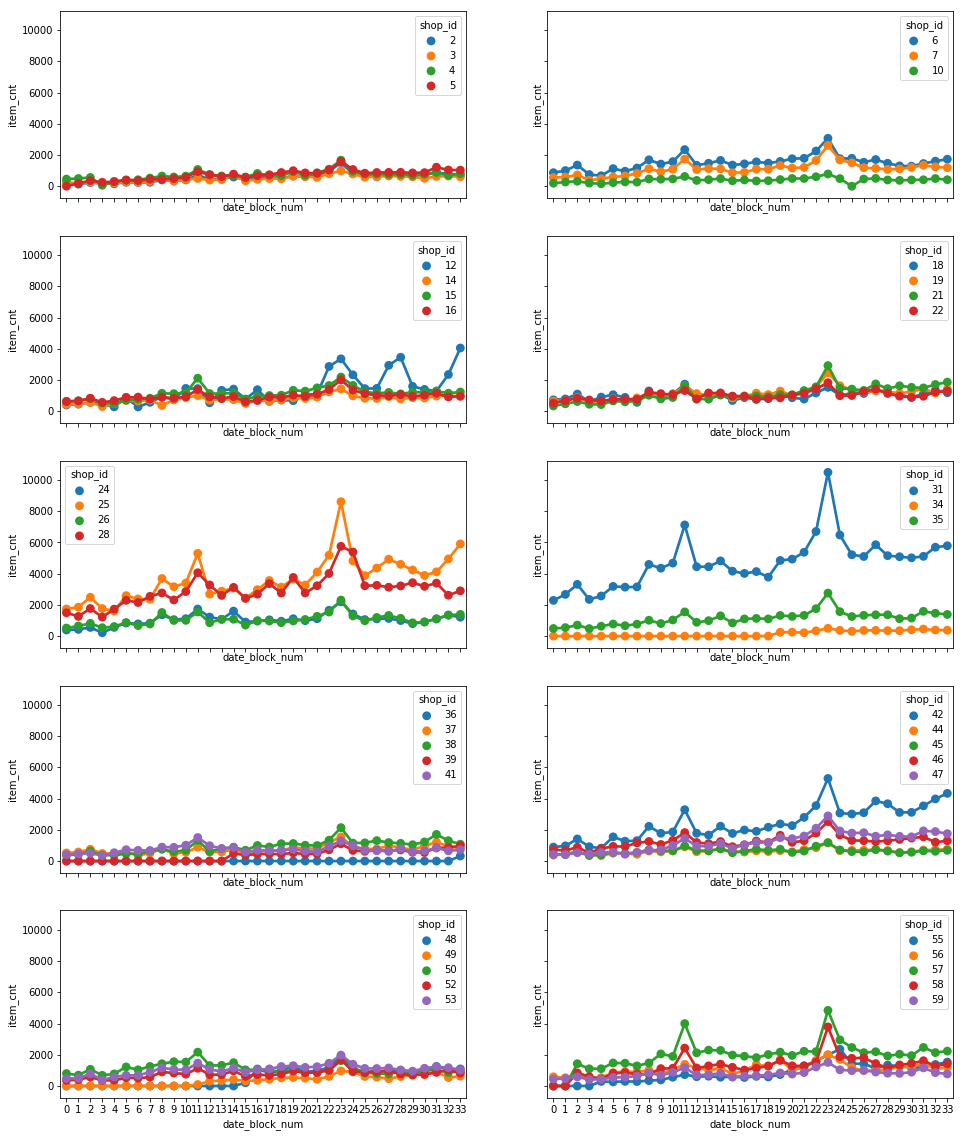

In [25]:
from math import ceil
group = pd.DataFrame(training_month.groupby(['shop_id', 'date_block_num'])['item_cnt'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
graph_num = 10
id_per_graph = ceil(group.shop_id.max() / graph_num)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt', hue='shop_id', data=group[np.logical_and(count*id_per_graph <= group['shop_id'], group['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [18]:
#Add year and month columns
training_month['year'] = training_month['date_block_num'].apply(lambda x: ((x//12) + 2013))
training_month['month'] = training_month['date_block_num'].apply(lambda x: (x % 12))
training_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0


In [19]:
#Grouping based on month, item_category, shop_id for EDA
gp_mean_monthly = training_month.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_sum_monthly = training_month.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_mean_category = training_month.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_sum_category = training_month.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_mean_shop = training_month.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_sum_shop = training_month.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

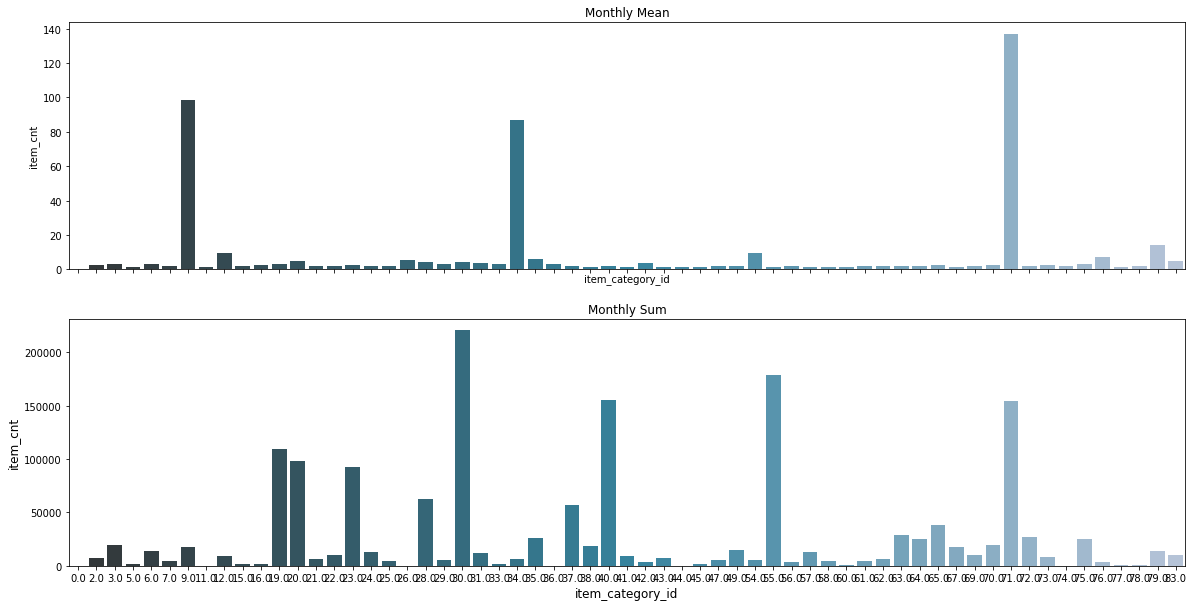

In [28]:
#Comparing icategory with item cnt
f, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)

sns.barplot(x="item_category_id", y="item_cnt", data=gp_mean_category, ax=axes[0], palette="PuBuGn_d").set_title("Monthly Mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_sum_category, ax=axes[1], palette="PuBuGn_d").set_title("Monthly Sum")

plt.show()

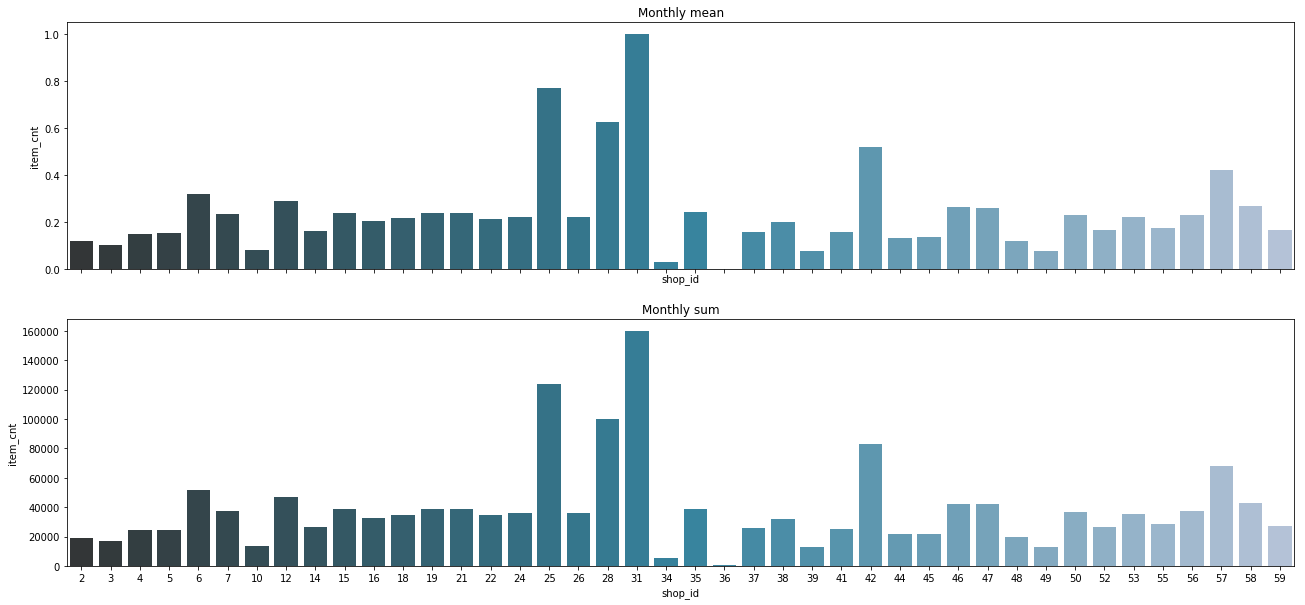

In [28]:
#Comparing shop id with item_cnt
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_mean_shop, ax=axes[0], palette="PuBuGn_d").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_sum_shop, ax=axes[1], palette="PuBuGn_d").set_title("Monthly sum")
plt.show()

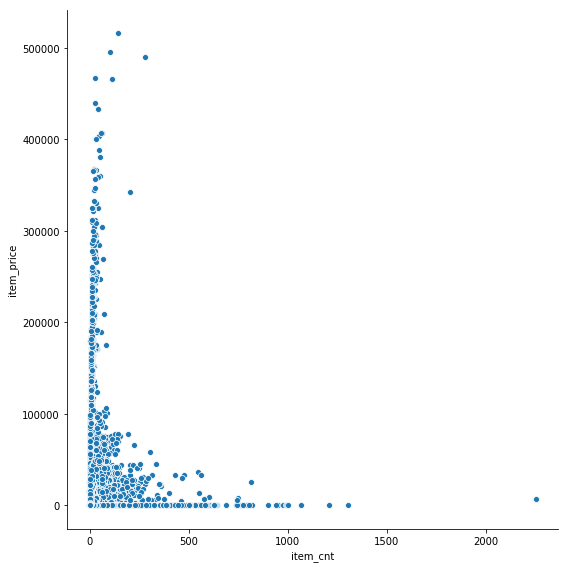

In [29]:
#Comparing item cnt with item pri
sns.relplot(x="item_cnt", y="item_price", data=training_month, height=8, sizes=20)
plt.show()

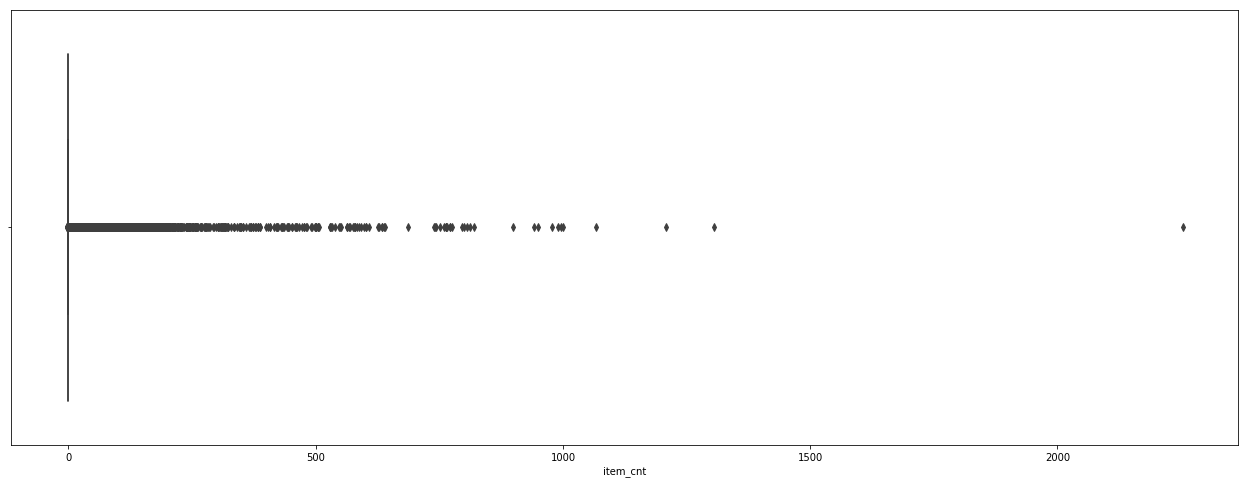

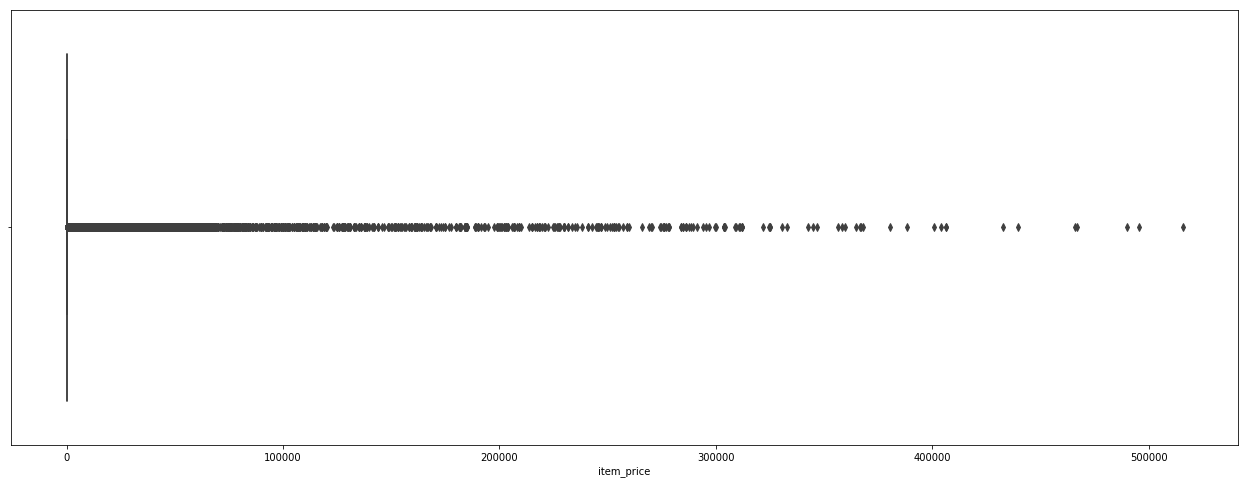

In [31]:
#Finding outliers in item cnt and item price
plt.subplots(figsize=(22, 8))
sns.boxplot(training_month['item_cnt'])

plt.subplots(figsize=(22, 8))
sns.boxplot(training_month['item_price'])

plt.show()

In [32]:
#Outlier removal
training_month = training_month.query('item_cnt >= 0 and item_cnt <=1000  and item_price < 400000')
training_month.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
count,6734181.00,6734181.00,6734181.00,6734181.00,6734181.00,6734181.00,6734181.00,6734181.00,6734181.00,6734181.00,6734181.00
mean,16.50,31.64,11041.98,3.79,186.54,81.02,0.24,0.10,0.18,2013.94,5.21
std,9.81,17.56,6210.74,13.21,2094.48,529.67,3.25,0.61,0.90,0.80,3.32
min,0.00,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,0.00
25%,8.00,16.00,5386.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,2.00
50%,16.00,35.00,11266.00,0.00,0.00,0.00,0.00,0.00,0.00,2014.00,5.00
75%,25.00,47.00,16069.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,8.00
max,33.00,59.00,22167.00,83.00,388163.34,42990.00,1000.00,1000.00,31.00,2015.00,11.00


In [44]:
#Creating the output varible
training_month['item_cnt_month'] = training_month.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
training_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00


FEATURE ENGINEERING 
is the process of extracting features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. 

In [21]:
#Unit price feature
training_month['item_price_unit'] = training_month['item_price'] // training_month['item_cnt']
training_month['item_price_unit'].fillna(0, inplace=True)
training_month.head()
train_original = training_month

In [22]:
#Group - taking min and max of itemprice
gp_price_item = training_month.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_price_item.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

training_month = pd.merge(training_month, gp_price_item, on='item_id', how='left')
training_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1192.00,0.00,18979.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00,0.00,35260.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,594.00,0.00,5592.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,1990.00,0.00,42630.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,1490.00,0.00,31290.00


In [23]:
#Change in price
training_month['price_increase'] = training_month['item_price'] - training_month['hist_min_item_price']
training_month['price_decrease'] = training_month['hist_max_item_price'] - training_month['item_price']
training_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1192.00,0.00,18979.50,10730.00,8249.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00,0.00,35260.00,4775.21,30484.79
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,594.00,0.00,5592.00,1188.30,4403.70
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,1990.00,0.00,42630.00,5970.00,36660.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,1490.00,0.00,31290.00,1490.00,29800.00


In [27]:
#LAG features
lag_list = [1, 2, 3]

for lag in lag_list:
    f_name = ('item_cnt_shifted%s' % lag)
    training_month[f_name] = training_month.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    training_month[f_name].fillna(0, inplace=True)

training_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,...,35260.00,4775.21,30484.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,5592.00,1188.30,4403.70,2.00,2.00,2.00,0.00,0.00,0.00,0.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,...,42630.00,5970.00,36660.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,31290.00,1490.00,29800.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00


In [28]:
#Item count trend
training_month['item_trend'] = training_month['item_cnt']

for lag in lag_list:
    f_name = ('item_cnt_shifted%s' % lag)
    training_month['item_trend'] -= training_month[f_name]

training_month['item_trend'] /= len(lag_list) + 1
training_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,...,4775.21,30484.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,1188.30,4403.70,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.50
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,...,5970.00,36660.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,1490.00,29800.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25


In [24]:
#ROLLING WINDOW
fn_minimum = lambda x: x.rolling(window=3, min_periods=1).min()
fn_maximum = lambda x: x.rolling(window=3, min_periods=1).max()

fn_mean = lambda x: x.rolling(window=3, min_periods=1).mean()

fn_std = lambda x: x.rolling(window=3, min_periods=1).std(

fn_list = [fn_minimum, fn_maximum, fn_mean, fn_std]
fn_name = ['min', 'max', 'mean', 'std']

In [25]:
for i in range(len(fn_list)):
    training_month[('item_cnt_%s' % fn_name[i])] = training_month.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(fn_list[i])

#fill empty features = 0
training_month['item_cnt_std'].fillna(0, inplace=True)

In [26]:
training_month

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00,0.00,35260.00,4775.21,30484.79,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,594.00,0.00,5592.00,1188.30,4403.70,2.00,2.00,2.00,0.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,1990.00,0.00,42630.00,5970.00,36660.00,3.00,3.00,3.00,0.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,1490.00,0.00,31290.00,1490.00,29800.00,1.00,1.00,1.00,0.00


In [42]:
training_month.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [43]:
training_month.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734181.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6734181.00,31.64,17.56,2.00,16.00,35.00,47.00,59.00
item_id,6734181.00,11041.98,6210.74,30.00,5386.00,11266.00,16069.00,22167.00
item_category_id,6734181.00,3.79,13.21,0.00,0.00,0.00,0.00,83.00
item_price,6734181.00,186.54,2094.48,0.00,0.00,0.00,0.00,388163.34
mean_item_price,6734181.00,81.02,529.67,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734181.00,0.24,3.25,0.00,0.00,0.00,0.00,1000.00
mean_item_cnt,6734181.00,0.10,0.61,0.00,0.00,0.00,0.00,1000.00
transactions,6734181.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00
year,6734181.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


In [44]:
training_dataset = training_month.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_dataset = training_month.query('date_block_num >= 28 and date_block_num < 33').copy()
testing_dataset = training_month.query('date_block_num == 33').copy()

training_dataset.dropna(subset=['item_cnt_month'], inplace=True)
validation_dataset.dropna(subset=['item_cnt_month'], inplace=True)

training_dataset.dropna(inplace=True)
validation_dataset.dropna(inplace=True)

print('training dataset records:', training_dataset.shape[0])
print('Validation dataset records:', validation_dataset.shape[0])
print('testing  dataset records:', testing_dataset.shape[0])

print('training dataset records: %s (%.f%% of complete data)' % (training_dataset.shape[0], ((training_dataset.shape[0]/training_month.shape[0])*100)))
print('validation dataset records: %s (%.f%% of complete data)' % (validation_dataset.shape[0], ((validation_dataset.shape[0]/training_month.shape[0])*100)))

training dataset records: 4951607
Validation dataset records: 990295
testing  dataset records: 198063
training dataset records: 4951607 (74% of complete data)
validation dataset records: 990295 (15% of complete data)


In [45]:
#mean encoding

#shop 
gp_mean_shop = training_dataset.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_mean_shop.columns = ['shop_mean']
gp_mean_shop.reset_index(inplace=True)
#item 
gp_mean_item = training_dataset.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_mean_item.columns = ['item_mean']
gp_mean_item.reset_index(inplace=True)
#shop_item
gp_mean_shop_item = training_dataset.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_mean_shop_item.columns = ['shop_item_mean']
gp_mean_shop_item.reset_index(inplace=True)
#year
gp_mean_yearly = training_dataset.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_mean_yearly.columns = ['year_mean']
gp_mean_yearly.reset_index(inplace=True)
#monthly
gp_mean_monthly = training_dataset.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_mean_monthly.columns = ['month_mean']
gp_mean_monthly.reset_index(inplace=True)

training_dataset = pd.merge(training_dataset, gp_mean_shop, on=['shop_id'], how='left')
training_dataset = pd.merge(training_dataset, gp_mean_item, on=['item_id'], how='left')
training_dataset = pd.merge(training_dataset, gp_mean_shop_item, on=['shop_id', 'item_id'], how='left')
training_dataset = pd.merge(training_dataset, gp_mean_yearly, on=['year'], how='left')
training_dataset = pd.merge(training_dataset, gp_mean_monthly, on=['month'], how='left')

validation_dataset = pd.merge(validation_dataset, gp_mean_shop, on=['shop_id'], how='left')
validation_dataset = pd.merge(validation_dataset, gp_mean_item, on=['item_id'], how='left')
validation_dataset = pd.merge(validation_dataset, gp_mean_shop_item, on=['shop_id', 'item_id'], how='left')
validation_dataset = pd.merge(validation_dataset, gp_mean_yearly, on=['year'], how='left')
validation_dataset = pd.merge(validation_dataset, gp_mean_monthly, on=['month'], how='left')

In [46]:
#training, validation dataset and label 
X_training_dataset = training_dataset.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_training_dataset = training_dataset['item_cnt_month'].astype(int)
X_validation_dataset = validation_dataset.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation_dataset = validation_dataset['item_cnt_month'].astype(int)

In [47]:
latest_records = pd.concat([training_dataset, validation_dataset]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test_data = pd.merge(test_data, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test_data['year'] = 2015
X_test_data['month'] = 9
X_test_data.drop('item_cnt_month', axis=1, inplace=True)

#integer features
integer_feature = ['shop_id', 'item_id', 'year', 'month']

X_test_data[integer_feature] = X_test_data[integer_feature].astype('int32')
X_test_data = X_test_data[X_training_dataset.columns]


In [49]:
set = [X_training_dataset, X_validation_dataset, X_test_data]

#replace missing values with median of each shop            
for dataset in set:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
#fill missing values on test dataset with mean
X_test_data.fillna(X_test_data.mean(), inplace=True)

In [50]:
#dropping item_category_id
X_training_dataset.drop(['item_category_id'], axis=1, inplace=True)
X_validation_dataset.drop(['item_category_id'], axis=1, inplace=True)
X_test_data.drop(['item_category_id'], axis=1, inplace=True)

In [51]:
X_test_data.head().T

,0,1,2,3,4
shop_id,5.00,5.00,5.00,5.00,5.00
item_id,5037.00,5320.00,5233.00,5232.00,5268.00
item_price,749.50,0.00,2997.00,0.00,0.00
mean_item_price,749.50,0.00,999.00,0.00,0.00
item_cnt,1.00,0.00,3.00,0.00,0.00
mean_item_cnt,1.00,0.00,1.00,0.00,0.00
transactions,1.00,0.00,3.00,0.00,0.00
year,2015.00,2015.00,2015.00,2015.00,2015.00
month,9.00,9.00,9.00,9.00,9.00
item_price_unit,749.00,0.00,999.00,0.00,0.00


In [54]:
X_test_data.head()
#integer features
integer_feature = ['shop_id', 'item_id', 'year', 'month']

X_training_dataset[integer_feature] = X_training_dataset[integer_feature].astype('int32')
X_validation_dataset[integer_feature] = X_validation_dataset[integer_feature].astype('int32')
X_training_dataset.dtypes

shop_id                  int32
item_id                  int32
item_price             float32
mean_item_price        float32
item_cnt               float64
mean_item_cnt          float64
transactions           float64
year                     int32
month                    int32
item_price_unit        float64
hist_min_item_price    float32
hist_max_item_price    float32
price_increase         float32
price_decrease         float32
item_cnt_min           float64
item_cnt_max           float64
item_cnt_mean          float64
item_cnt_std           float64
item_cnt_shifted1      float64
item_cnt_shifted2      float64
item_cnt_shifted3      float64
item_trend             float64
shop_mean              float64
item_mean              float64
shop_item_mean         float64
year_mean              float64
month_mean             float64
dtype: object

In [56]:
cat_features = [0, 1, 7, 8]

model_catboost = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

model_catboost.fit(
    X_training_dataset, Y_training_dataset,
    cat_features=cat_features,
    eval_set=(X_validation_dataset, Y_validation_dataset)
)

Learning rate set to 0.354271
0:	learn: 2.9368054	test: 1.8325483	best: 1.8325483 (0)	total: 3.76s	remaining: 31m 14s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 1.389252697
bestIteration = 6

Shrink model to first 7 iterations.


In [57]:
print('model parameters:', model_catboost.get_params())


model parameters: {'max_ctr_complexity': 4, 'verbose': 50, 'random_seed': 0, 'od_type': 'Iter', 'od_wait': 25, 'loss_function': 'RMSE', 'depth': 4, 'iterations': 500}


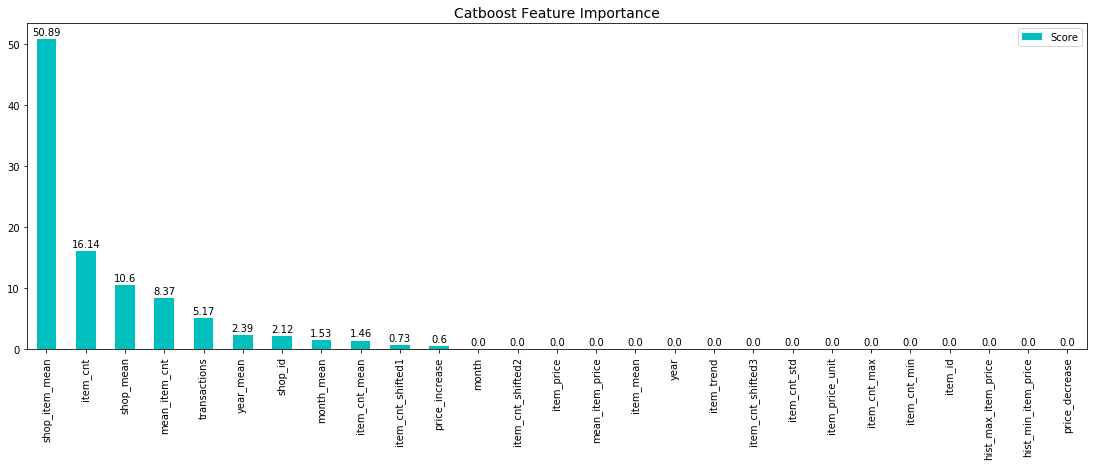

In [58]:
feature_score = pd.DataFrame(list(zip(X_training_dataset.dtypes.index, model_catboost.get_feature_importance(Pool(X_training_dataset, label=Y_training_dataset, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [59]:
#integer features
integer_feature = ['shop_id', 'item_id', 'year', 'month']

X_test_data[integer_feature] = X_test_data[integer_feature].astype('int32')
X_test_data.dtypes

shop_id                  int32
item_id                  int32
item_price             float32
mean_item_price        float32
item_cnt               float64
mean_item_cnt          float64
transactions           float64
year                     int32
month                    int32
item_price_unit        float64
hist_min_item_price    float32
hist_max_item_price    float32
price_increase         float32
price_decrease         float32
item_cnt_min           float64
item_cnt_max           float64
item_cnt_mean          float64
item_cnt_std           float64
item_cnt_shifted1      float64
item_cnt_shifted2      float64
item_cnt_shifted3      float64
item_trend             float64
shop_mean              float64
item_mean              float64
shop_item_mean         float64
year_mean              float64
month_mean             float64
dtype: object

In [61]:
catboost_training_prediction = model_catboost.predict(X_training_dataset)
catboost_validation_prediction = model_catboost.predict(X_validation_dataset)
catboost_test_prediction = model_catboost.predict(X_test_data)


In [62]:
print('training dataset error rate:', np.sqrt(mean_squared_error(Y_training_dataset, catboost_training_prediction)))
print('validation dataset error rate:', np.sqrt(mean_squared_error(Y_validation_dataset, catboost_validation_prediction)))


training dataset error rate: 2.013284379202982
validation dataset error rate: 1.3892526966214962


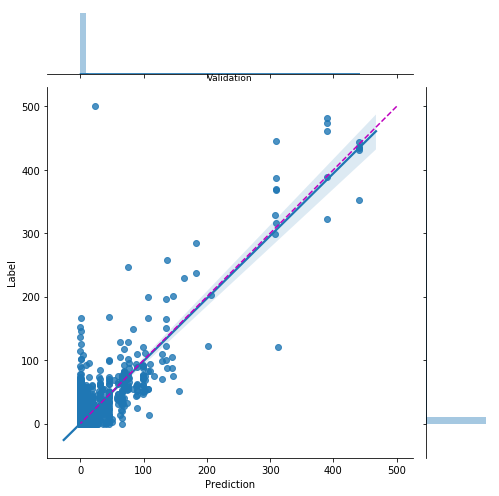

In [63]:
def model_performance_sc_plot(predictions, labels, title):
    #get min, max values of predictions and labels
    minimum_val = max(max(predictions), max(labels))
    maximum_val = min(min(predictions), min(labels))
    #dataframe - predictions & labels
    per_df = pd.DataFrame({"Label":labels})
    per_df["Prediction"] = predictions
    #plot data
    sns.jointplot(y="Label", x="Prediction", data=per_df, kind="reg", height=7)
    plt.plot([minimum_val, maximum_val], [minimum_val, maximum_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
#model_performance_sc_plot(catboost_training_prediction, Y_training_dataset, 'Train')
model_performance_sc_plot(catboost_validation_prediction, Y_validation_dataset, 'Validation')


XGBOOST ( Extreme Gradient Boosting )

In [65]:
xgboost_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgboost_train = X_training_dataset[xgboost_features]
xgboost_val = X_validation_dataset[xgboost_features]
xgboost_test = X_test_data[xgboost_features]


In [66]:
xgboost_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgboost_model.fit(xgboost_train, 
              Y_training_dataset, 
              eval_metric="rmse", 
              eval_set=[(xgboost_train, Y_training_dataset), (xgboost_val, Y_validation_dataset)], 
              verbose=20, 
              early_stopping_rounds=20)

[13:23:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:3.28496	validation_1-rmse:2.21272
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:2.82654	validation_1-rmse:1.92619
[40]	validation_0-rmse:2.77574	validation_1-rmse:1.87131
[60]	validation_0-rmse:2.76226	validation_1-rmse:1.86184
[80]	validation_0-rmse:2.74960	validation_1-rmse:1.85123
[100]	validation_0-rmse:2.73661	validation_1-rmse:1.83879
[120]	validation_0-rmse:2.72645	validation_1-rmse:1.82910
[140]	validation_0-rmse:2.72121	validation_1-rmse:1.82435
[160]	validation_0-rmse:2.71077	validation_1-rmse:1.80661
[180]	validation_0-rmse:2.70443	validation_1-rmse:1.80064


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)

In [67]:
xgboost_training_prediction = xgboost_model.predict(xgboost_train)
xgboost_validation_prediction = xgboost_model.predict(xgboost_val)
xgboost_test_prediction = xgboost_model.predict(xgboost_test)

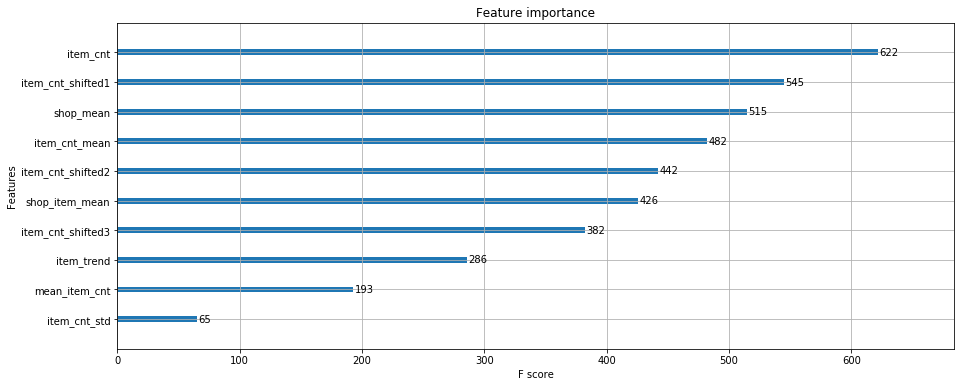

training dataset error rate: 2.6872675317542436
validation dataset error rate: 1.7728153544449914


In [68]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgboost_model)
plt.show()

print('training dataset error rate:', np.sqrt(mean_squared_error(Y_training_dataset, xgboost_training_prediction)))
print('validation dataset error rate:', np.sqrt(mean_squared_error(Y_validation_dataset, xgboost_validation_prediction)))

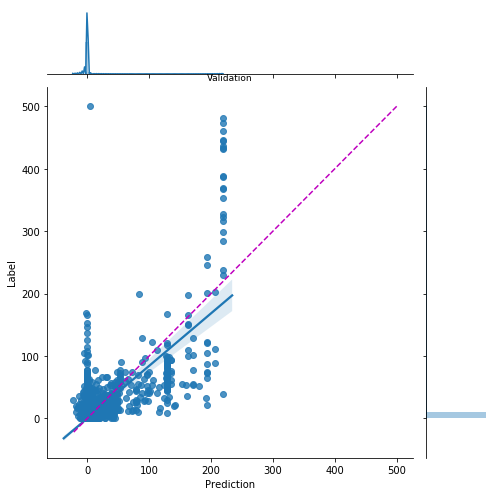

In [69]:
#model_performance_sc_plot(xgboost_training_prediction, Y_training_dataset, 'Train')
model_performance_sc_plot(xgboost_validation_prediction, Y_validation_dataset, 'Validation')

RANDOM FOREST

In [71]:
#use subset features on random forest
random_forest_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
random_forest_train = X_training_dataset[random_forest_features]
random_forest_val = X_validation_dataset[random_forest_features]
random_forest_test = X_test_data[random_forest_features]

In [72]:
random_forest_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
random_forest_model.fit(random_forest_train, Y_training_dataset)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [73]:
random_forest_train_pred = random_forest_model.predict(random_forest_train)
random_forest_val_pred = random_forest_model.predict(random_forest_val)
random_forest_test_pred = random_forest_model.predict(random_forest_test)

print('training dataset error rate:', np.sqrt(mean_squared_error(Y_training_dataset, random_forest_train_pred)))
print('validation dataset error rate:', np.sqrt(mean_squared_error(Y_validation_dataset, random_forest_val_pred)))

training dataset error rate: 1.8066582525371662
validation dataset error rate: 1.490383443802633


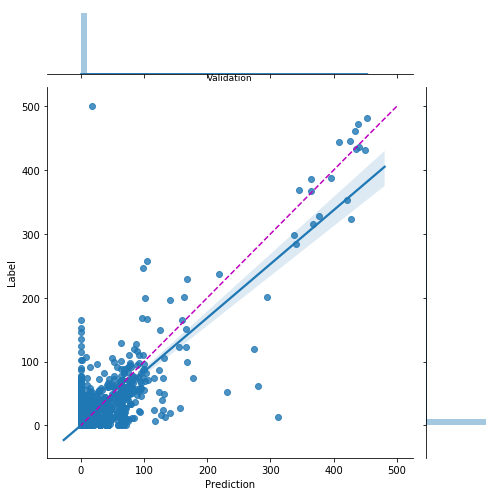

In [74]:
#model_performance_sc_plot(random_forest_train_pred, Y_training_dataset, 'Train')
model_performance_sc_plot(random_forest_val_pred, Y_validation_dataset, 'Validation')

In [76]:
#using subset features on linear regression
linear_reg_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
linear_reg_train = X_training_dataset[linear_reg_features]
linear_reg_val = X_validation_dataset[linear_reg_features]
linear_reg_test = X_test_data[linear_reg_features]

In [77]:
linear_reg_scaler = MinMaxScaler()
linear_reg_scaler.fit(linear_reg_train)

linear_reg_train = linear_reg_scaler.transform(linear_reg_train)
linear_reg_val = linear_reg_scaler.transform(linear_reg_val)
linear_reg_test = linear_reg_scaler.transform(linear_reg_test)

linear_reg_model = LinearRegression(n_jobs=-1)
linear_reg_model.fit(linear_reg_train, Y_training_dataset)


linear_reg_train_pred = linear_reg_model.predict(linear_reg_train)
linear_reg_val_pred = linear_reg_model.predict(linear_reg_val)
linear_reg_test_pred = linear_reg_model.predict(linear_reg_test)

print('training dataset error rate:', np.sqrt(mean_squared_error(Y_training_dataset, linear_reg_train_pred)))
print('validation dataset error rate:', np.sqrt(mean_squared_error(Y_validation_dataset, linear_reg_val_pred)))

training dataset error rate: 2.270678027633732
validation dataset error rate: 1.5151510350546087


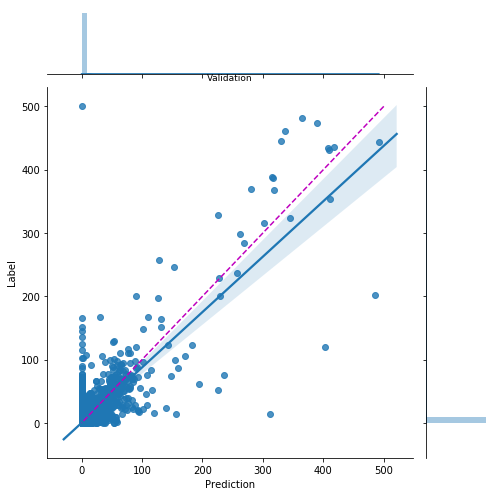

In [78]:
#model_performance_sc_plot(linear_reg_train_pred, Y_training_dataset, 'Train')
model_performance_sc_plot(linear_reg_val_pred, Y_validation_dataset, 'Validation')


In [80]:
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

#subsample training dataset
X_train_sample = X_training_dataset[:100000]
Y_train_sample = Y_training_dataset[:100000]

knn_train = X_train_sample[knn_features]
knn_val = X_validation_dataset[knn_features]
knn_test = X_test_data[knn_features]


knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sample)


knn_train_prediction = knn_model.predict(knn_train)
knn_val_prediction = knn_model.predict(knn_val)
knn_test_prediction = knn_model.predict(knn_test)


In [81]:
print('training dataset error rate:', np.sqrt(mean_squared_error(Y_train_sample, knn_train_prediction)))
print('validation dataset error rate:', np.sqrt(mean_squared_error(Y_validation_dataset, knn_val_prediction)))

training dataset error rate: 1.9333819917248445
validation dataset error rate: 2.3338813286433164


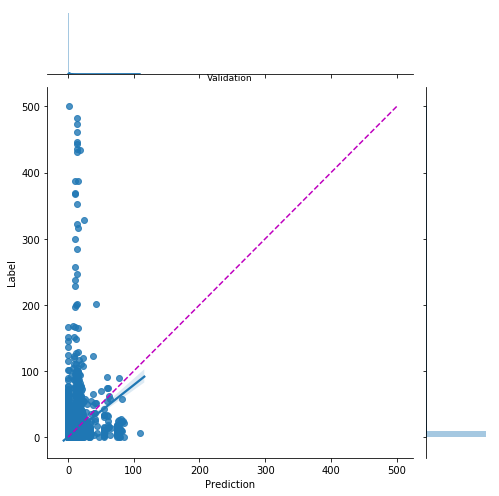

In [82]:
#model_performance_sc_plot(knn_train_prediction, Y_train_sample, 'Train')
model_performance_sc_plot(knn_val_prediction, Y_validation_dataset, 'Validation')

LEVELS

In [83]:
#training dataset of ensemble model
level_one = pd.DataFrame(catboost_validation_prediction, columns=['catboost'])
level_one['xgbm'] = xgboost_validation_prediction
level_one['random_forest'] = random_forest_val_pred
level_one['linear_regression'] = linear_reg_val_pred
level_one['knn'] = knn_val_prediction
level_one['label'] = Y_validation_dataset.values
level_one.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.60,0.83,0.65,0.57,1.00,0
1,0.40,1.18,0.67,0.05,0.67,0
2,0.10,0.04,0.20,0.05,0.00,0
3,1.69,2.61,1.02,0.05,0.00,4
4,1.22,1.91,1.91,1.65,0.56,1
5,0.40,0.87,0.65,0.05,0.00,1
6,0.40,0.53,0.23,0.05,0.11,0
7,0.10,0.04,0.04,0.05,0.00,1
8,0.10,0.44,0.30,0.05,0.11,0
9,1.89,1.84,1.35,1.27,0.67,2


In [84]:
level_one_test = pd.DataFrame(catboost_test_prediction, columns=['catboost'])
level_one_test['xgbm'] = xgboost_test_prediction
level_one_test['random_forest'] = random_forest_test_pred
level_one_test['linear_regression'] = linear_reg_test_pred
level_one_test['knn'] = knn_test_prediction
level_one_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.30,0.28,0.90,0.76,0.33
1,0.10,0.00,0.04,0.06,0.00
2,0.93,0.04,1.31,2.08,1.22
3,0.10,0.00,0.04,0.06,0.00
4,0.10,0.00,0.04,0.06,0.00


In [85]:
meta_model = LinearRegression(n_jobs=-1)

In [86]:
level_one.drop('label', axis=1, inplace=True)
meta_model.fit(level_one, Y_validation_dataset)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [87]:
ensemble_prediction = meta_model.predict(level_one)
final_prediction = meta_model.predict(level_one_test)

In [88]:
print('error rate:', np.sqrt(mean_squared_error(ensemble_prediction, Y_validation_dataset)))

error rate: 1.3568543144998089


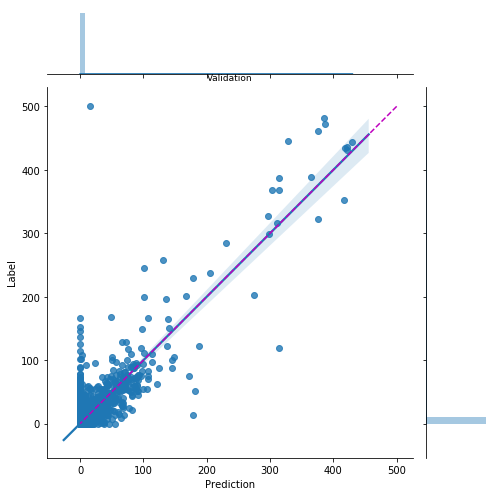

In [89]:
model_performance_sc_plot(ensemble_prediction, Y_validation_dataset, 'Validation')

In [ ]:
prediction_dataframe = pd.DataFrame(test_data['ID'], columns=['ID'])
prediction_dataframe['item_cnt_month'] = final_prediction.clip(0., 20.)
prediction_dataframe.to_csv('output/submission.csv', index=False)
prediction_dataframe.head(10)